In [32]:
from utils import *
from modeling import *
from plotting import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Measurement

mu: 460.20 , std: 4.02 , ZP: 27.10 , pix_scale: 2.50


/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log10


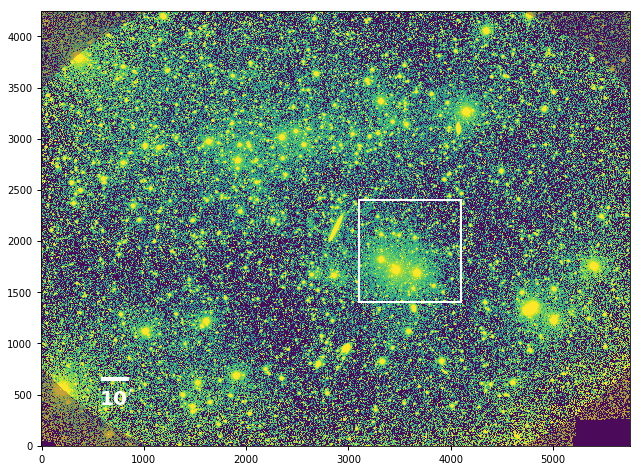

In [23]:
############################################
# Read 
############################################

R_scale = 10
obj_name = 'NGC5907-G'
band = 'G'
 
hdu = fits.open("./data/coadd_Sloan%s_NGC_5907.fits"%band)[0]
data = hdu.data
header = hdu.header
wcs_data = wcs.WCS(header)

# Runned from create_photometric_light_APASS 
seg_map = fits.getdata("./SE_APASS/coadd_Sloan%s_NGC_5907_seg.fits"%band)
seg_map_dilation = seg_map.copy()
for i in range(5):
    seg_map_dilation= morphology.dilation(seg_map_dilation)

weight_edge = fits.getdata("./weight_NGC5907.fits")
SE_cat_full = Table.read("./SE_APASS/coadd_Sloan%s_NGC_5907.cat"%band,
                         format="ascii.sextractor")

mu = np.float(header["BACKVAL"])
ZP, pix_scale = np.float(hdu.header["REFZP"]), np.float(hdu.header["PIXSCALE"])

data_clip = sigma_clip(data[seg_map_dilation==0&(weight_edge>0.5)], sigma=3, maxiters=10)
std = np.std(data_clip) 

print("mu: %.2f , std: %.2f , ZP: %.2f , pix_scale: %.2f" %(mu, std, ZP, pix_scale))

SE_cat_full["MAG_AUTO"] = np.around(-2.5*np.log10(SE_cat_full["FLUX_AUTO"]) + ZP, 5)

############################################
# Crop
############################################
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (800, 1800, 1800, 2800)
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (2400, 1500, 3400, 2500)
patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (3100, 1400, 4100, 2400)
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (3000, 1400, 4200, 2600)
catalog_bounds = (patch_Xmin-50, patch_Ymin-50, patch_Xmax+50, patch_Ymax+50)
image_size = patch_Xmax - patch_Xmin

image_bounds = (patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax)
        
patch, seg_patch = crop_image(data, image_bounds, weight_map=weight_edge, SE_seg_map=seg_map, 
                              sky_mean=mu, sky_std=std, color="w",draw=True)

In [3]:
# Crossmatch with star catalog
############################################
tab_target, tab_target_full, catalog_star = cross_match(header, SE_cat_full,
                                                              catalog_bounds, mag_thre=15, mag_name='rmag')
tab_target[:10]

Pan-STARRS rmag:  6.675 ~ 22.801
Pan-STARRS gmag:  7.754 ~ 26.614
Matched stars with Pan-STARRS rmag:  6.675 ~ 21.938
Matched bright stars with Pan-STARRS rmag:  6.675 ~ 14.991


NUMBER,FLUX_AUTO,X_IMAGE,Y_IMAGE,X_WORLD,Y_WORLD,FWHM_IMAGE,FLAGS,MAG_AUTO,ID_PS,gmag_PS,rmag_PS,X_IMAGE_PS,Y_IMAGE_PS
,ct,pix,pix,deg,deg,pix,,,,mag,mag,pix,pix
int64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64
19063,6369070.0,3466.0796,1721.5258,228.24070208,56.046451325,7.07,6,10.08596,3014,7.7540,6.6749,3466.0151,1721.6087
19617,5273856.0,3670.7646,1693.4302,227.98675202,56.025171198,6.63,6,10.29083,5398,7.8390,7.9680,3670.3764,1693.3941
18466,3842712.0,3321.3972,1824.0864,228.41955121,56.118606551,5.57,4,10.63456,3127,7.9324,8.6055,3321.2541,1824.2012
20822,1571271.0,3834.8767,1565.9124,227.78560648,55.934841547,3.93,4,11.60553,3807,10.4674,10.4994,3834.8505,1565.9065
16517,1554580.0,3497.1108,2059.6765,228.19737532,56.281019314,9.2,4,11.61712,6617,11.2690,10.9980,3497.8032,2060.6086
16430,1538869.0,3322.2563,2066.9353,228.41602509,56.287237808,4.17,4,11.62815,6266,10.6110,10.2440,3322.3262,2066.843
21048,1433815.0,3634.0322,1540.8929,228.03497774,55.919617353,3.82,6,11.70492,2394,11.6498,10.4833,3634.1619,1540.8524
16683,1361611.0,3652.0815,2038.4492,228.00391739,56.264914082,4.03,4,11.76102,6521,11.1040,10.8710,3651.9928,2038.4448


Color Term = -0.12466


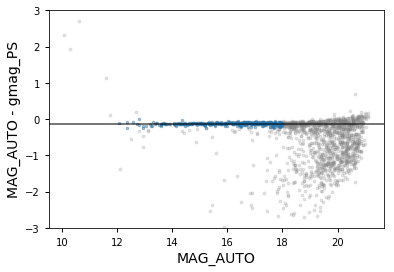

In [4]:
# Calculate color correction of PANSTAR and DF
CT = calculate_color_term(tab_target_full, mag_name='gmag_PS')
catalog_star["GMAG_AUTO"] = catalog_star["gmag"] + CT

In [5]:
# Save matched table and catalog 
tab_target_name = './Measure/%s-catalog_match_X%sY%s.txt'%(obj_name, patch_Xmin, patch_Ymin)
tab_target.write(tab_target_name, overwrite=True, format='ascii')

catalog_star_name = './Measure/%s-catalog_PS_X%sY%s.txt'%(obj_name, patch_Xmin, patch_Ymin)
catalog_star.write(catalog_star_name, overwrite=True, format='ascii')

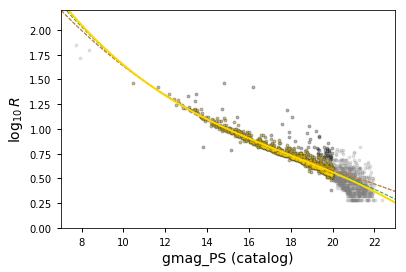


Make segmentation map based on catalog PS gmag: 8262 stars


In [25]:
# Make segmentation map from catalog based on SE
estimate_radius = fit_empirical_aperture(tab_target_full, seg_map, mag_name='gmag_PS',
                                         mag_range=[12,20], K=2, degree=3, draw=True)

seg_map_cat = make_segm_from_catalog(catalog_star, image_bounds, estimate_radius,
                                     mag_name='gmag', cat_name='PS')

In [34]:
def make_segm_from_catalog(catalog, image_bounds, estimate_radius,
                           mag_name='rmag', cat_name='PS'):
    """ Make segmentation , aperture size from SE is fit based on SE"""
    R_est = np.array([estimate_radius(m) for m in catalog[mag_name]])
    Xmin, Ymin = image_bounds[:2]
    
    apers = [CircularAperture((X_c-Xmin, Y_c-Ymin), r=r)
             for (X_c,Y_c, r) in zip(catalog['X_IMAGE'+'_'+cat_name],
                                     catalog['Y_IMAGE'+'_'+cat_name], R_est)] 
    
    image_size = image_bounds[2] - image_bounds[0]
    seg_map_catalog = np.zeros((image_size, image_size))
    
    # Segmentation k sorted by mag of source catalog
    for (k, aper) in enumerate(apers):
        star_ma = aper.to_mask(method='center').to_image((image_size, image_size))
        if star_ma is not None:
            seg_map_catalog[star_ma.astype(bool)] = k+2
            
    return seg_map_catalog


Fit 3th empirical relation of (X1) aperture radii for catalog stars based on SE.


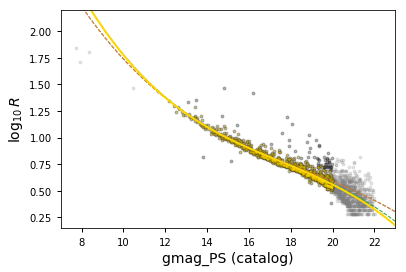

In [35]:
# Make segmentation map from catalog based on SE
estimate_radius = fit_empirical_aperture(tab_target_full, seg_map, mag_name='gmag_PS',
                                         mag_range=[12,20], K=1.5, degree=3, draw=True)

seg_map_cat = make_segm_from_catalog(catalog_star, image_bounds, estimate_radius,
                                     mag_name='gmag', cat_name='PS')

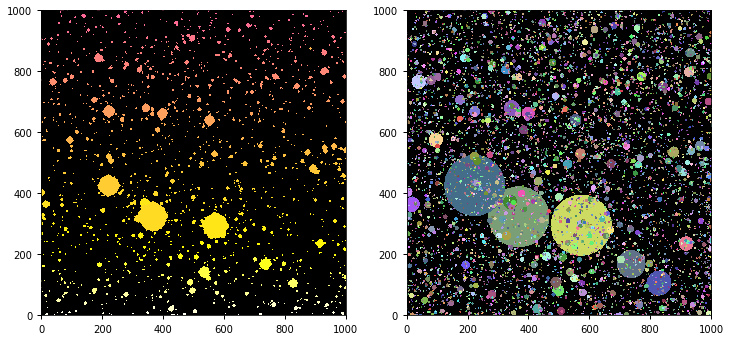

In [7]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(seg_patch)
ax2.imshow(seg_map_cat, vmin=1, cmap=make_rand_cmap(12000))

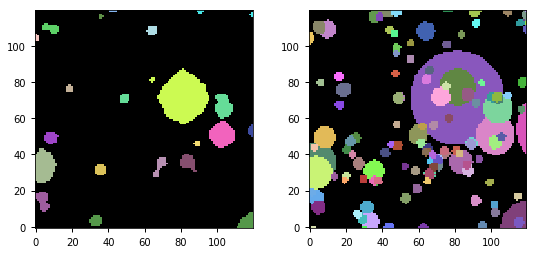

In [8]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,4))

ax1.imshow(seg_patch[607:727,262:382],vmin=1, cmap=make_rand_cmap(1000))

ax2.imshow(seg_map_cat[607:727,262:382],vmin=1, cmap=make_rand_cmap(12000))

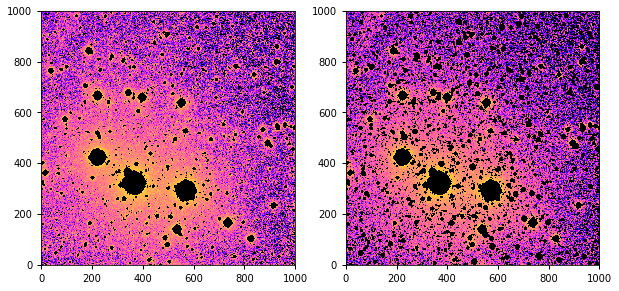

In [9]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
patch2=patch.copy()
patch2[seg_patch>0] = 0
ax1.imshow(patch2, vmin=mu-2, vmax=540, norm=norm1)
patch2=patch.copy()
patch2[(seg_map_cat>50)|(seg_patch>0)] = 0
ax2.imshow(patch2, vmin=mu-2, vmax=540, norm=norm1)

In [10]:
# Save segmentation map built from catalog
hdu_seg = fits.PrimaryHDU(seg_map_cat.astype(float))
hdu_seg.writeto("Seg_PS_X%dY%d.fits" %(patch_Xmin, patch_Ymin), overwrite=True)

In [11]:
# Measure average intensity (source+background) at R_scale
tab_res_Rnorm, res_thumb = measure_Rnorm_all(tab_target, image_bounds,
                                             wcs_data, data, seg_map, 
                                             R_scale=10, mag_thre=15, 
                                             obj_name=obj_name, mag_name='rmag_PS', 
                                             read=False, save=True, dir_name='./Measure')

completed: 27/137
completed: 54/137
Errorenous measurement: # 19088
completed: 81/137
completed: 108/137
completed: 135/137
Results will be saved in ./Measure

Save thumbs to: ./Measure/NGC5907-G-thumbnail_r15mag_X3100Y1400.pkl


## Plotting

NUMBER:  12025
X_c, Y_c:  (3936.4358, 2605.7576)
RA, DEC:  (227.63464689, 56.655475736)
x_min, x_max, y_min, y_max:  2451 2759 3781 4089
X_min, X_max, Y_min, Y_max:  3782.4358 4090.4358 2451.7576 2759.7576


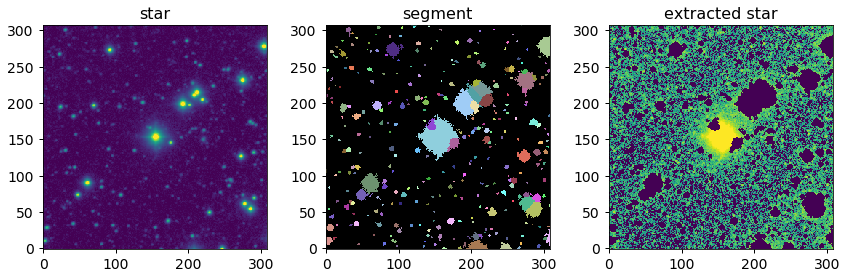

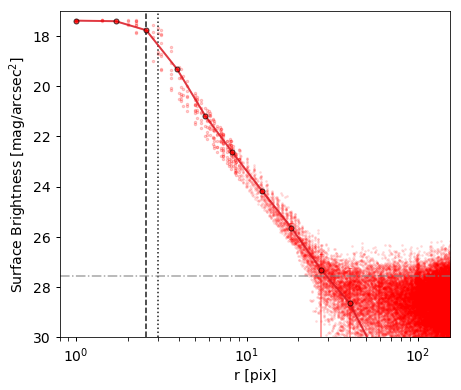

In [193]:
num = 12025
id = num-1
img_thumb, star_ma, star_bkg, cen_star = extract_star(id, SE_cat_full, wcs_data, data, seg_map=None,
                                                      n_win=40, sn_thre=3, display_bg=False, display=True, verbose=True)

obj = tab_SE_target[tab_SE_target['NUMBER']==num]

plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_thumb, cen=cen_star, mask=star_ma, 
                                              ZP=ZP, sky_mean=mu, sky_std=std,
                                              xunit="pix", yunit="SB", color="r",
                                              scatter=True, errorbar=True, plot_line=True)

plt.xscale("log")

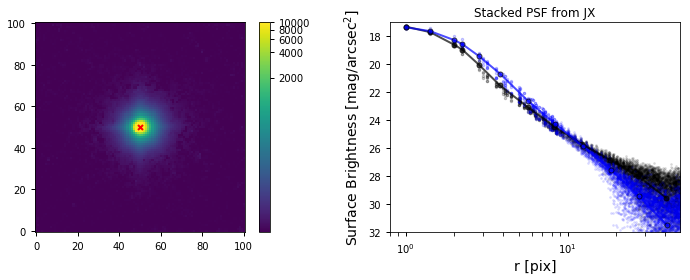

In [87]:
# Read median stack PSF
hdu = fits.open("./med_psf_JX.fits")[0]
hdu_p = fits.open("./median_psf_patch.fits")[0]
PSF_JX = hdu.data * 10 + mu
PSF_JX_p = hdu_p.data * 1e5 + mu

fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
im = ax1.imshow(PSF_JX_p, vmin=mu, vmax=10000, norm=norm1, aspect="equal", origin="lower", cmap="viridis")
ax1.plot(50,50,"rx",ms=5,mew=2)
colorbar(im)

ax2 = plt.subplot(122)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50),
                                             ZP=ZP, sky_mean=mu, sky_std=1, pixel_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="k",
                                             scatter=True, core_undersample=True)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX_p, cen=(50,50),
                                             ZP=ZP, sky_mean=mu, sky_std=1, pixel_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="b",
                                             scatter=True, core_undersample=True)
plt.ylim(32,17)
plt.title("Stacked PSF from JX")
plt.tight_layout()

NUMBER:  19088
X_c, Y_c:  (3441.7869, 1756.2905)
RA, DEC:  (228.27046103, 56.070766786)
x_min, x_max, y_min, y_max:  1655 1855 3341 3541
X_min, X_max, Y_min, Y_max:  3341.7869 3541.7869 1656.2905 1856.2905


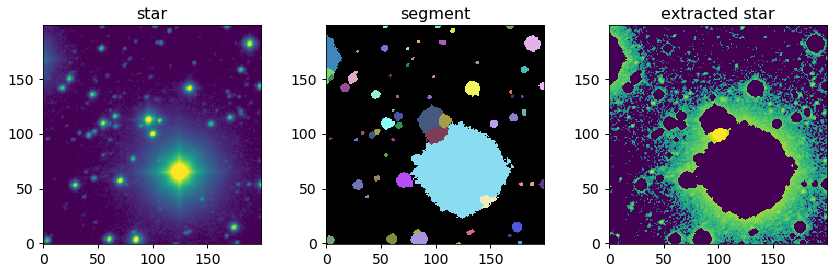

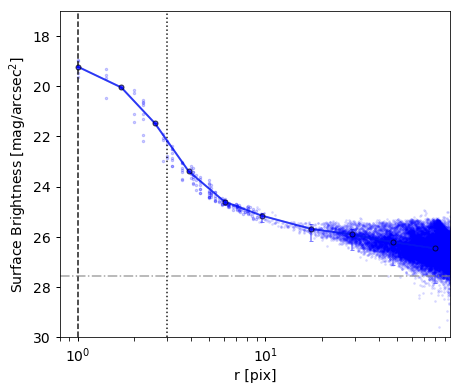

In [194]:
num = 19088
id = num-1
img_thumb, star_ma, star_bkg, cen_star = extract_star(id, SE_cat_full, wcs_data, data, seg_map=None,
                                                      n_win=40, sn_thre=3, display_bg=False, display=True, verbose=True)

obj = tab_SE_target[tab_SE_target['NUMBER']==num]

plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_thumb, cen=cen_star, mask=star_ma, 
                                              ZP=ZP, sky_mean=mu, sky_std=std,
                                              xunit="pix", yunit="SB", color="b",
                                              scatter=True, errorbar=True, plot_line=True)

plt.xscale("log")

In [11]:
import random
colour = [ "indianred", "steelblue", "seagreen", "gold", "lightcyan", "orchid", "orange", "gray", "brown" ]
random.seed(88)
rand_colours = [random.choice(colour) for i in range(len(tab_SE_target))]

psf = PSF_Model(params={"fwhm":2.28*pix_scale, "beta":10, 'theta_0':5},
                aureole_model='power', pixel_scale=2.5)

In [56]:
def plot_PSF(fit_res, res_thumb, tab_target, 
             r_core=12, pixel_scale=pix_scale, mag_name='rmag_PS',
             plot_stars=True, plot_stack=None, color='r', **kwargs):
    r = np.logspace(0.03,2.5,100)
    pmed, pmean, pcov = get_params_fit(fit_res1)    
    I_tot_A, I_tot_B, I_tot_C = plot_fit_res_SB(pmed, psf, r=r, **kwargs)
    mu_fit, std_fit = pmed[-2], pmed[-1]
    mu = 884
    
    z_mean_s, z_med_s = table_res_Rnorm['mean'],table_res_Rnorm['med'] 
    z_std_s, sky_mean_s = table_res_Rnorm['std'],table_res_Rnorm['sky']

    plt.figure(figsize=(10,8))
    for num, rmag, sky_m, c in zip(tab_target["NUMBER"], tab_target[mag_name], sky_mean_s, rand_colours):
        img, ma, cen = res_thumb[num]['image'], res_thumb[num]['mask'], res_thumb[num]['center']
        alpha = min(0.1*(16-rmag), 0.7) 
        errorbar = True if rmag<10 else False
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                                      ZP=ZP, sky_mean=mu, sky_std=std_fit, dr=1.5,
                                                      xunit="pix", yunit="SB", errorbar=errorbar,
                                                      color=c, lw=1, alpha=alpha)

    plt.fill_betweenx([32, 16.], x1=R_scale-0.5, x2=R_scale+0.5, color="gold", alpha=0.3)
    
    if plot_stars:
        for z_m, z_std, sky_m, c in zip(z_mean_s, z_std_s, sky_mean_s, rand_colours):
            plt.plot(R_scale, Intensity2SB(z_m, sky_m, ZP, pixel_scale),"*", ms=10, color=c, alpha=0.5, zorder=3)
            
    if plot_stack is not None:
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(plot_stack, cen=(50,50), mask=None,
                                                      ZP=ZP, sky_mean=mu, sky_std=std_fit,
                                                      pix_scale=pixel_scale, dr=1,
                                                      xunit="pix", yunit="SB", color="k",
                                                      lw=4, label="Stacked PSF (JX)",
                                                      core_undersample=True, plot_line=False)
    for k, I in enumerate([I_tot_C, I_tot_B, I_tot_A]):
        lab = "Fit (1D profile)" if k==0 else None
        plt.plot(r[r>12], I[r>12], color=color, ls="--", lw=3, label=lab, zorder=3, alpha=0.9)
    plt.axvspan(12, 24, color="steelblue",  alpha=0.1)
    plt.axvspan(24, 65, color="seagreen", alpha=0.1)
    plt.axvspan(0.8, 12, color="gray", alpha=0.2, label="Mask")
    plt.axhline(mu)
    plt.legend(fontsize=14)
    plt.ylim(32,17.)
    plt.xlim(1,220)

### Patch [800, 1800, 800, 2800] stars < 15 mag

In [26]:
fit_res1 = open_nested_fitting_result(filename='./real/fit_real_best_X800Y1800.res')
res_thumb1 = load_thumbs('%s-Thumb_15mag_X800Y1800'%obj_name)

In [27]:
plot_PSF(fit_res1, res_thumb1)

### R-band Patch [3100, 1400, 4100, 2400]  containing brighter stars

In [57]:
fit_res1 = open_nested_fitting_result(filename='./real/fit_real_best_X3100Y1400.res')
res_thumb1 = load_thumbs('%s-Thumb_15mag_X3100Y1400'%obj_name)

Read thumbs from: NGC5907-R-Thumb_15mag_X3100Y1400


Fit results:  [-6.50509899e-01  3.37575963e+00  8.86088255e+02  2.99074134e+00]


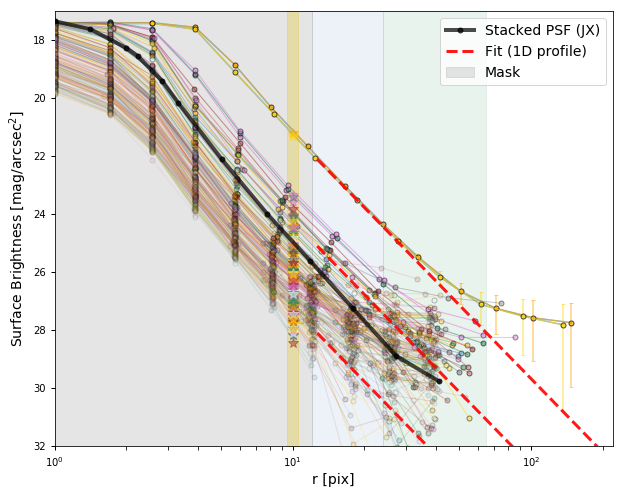

In [58]:
plot_PSF(fit_res1, res_thumb1, tab_SE_target,
         plot_stack=PSF_JX_p, mags=[14, 11, 8], ZP=ZP)

Fit results:  [-6.50495723e-01  3.37575243e+00  8.86088254e+02  2.99072081e+00]


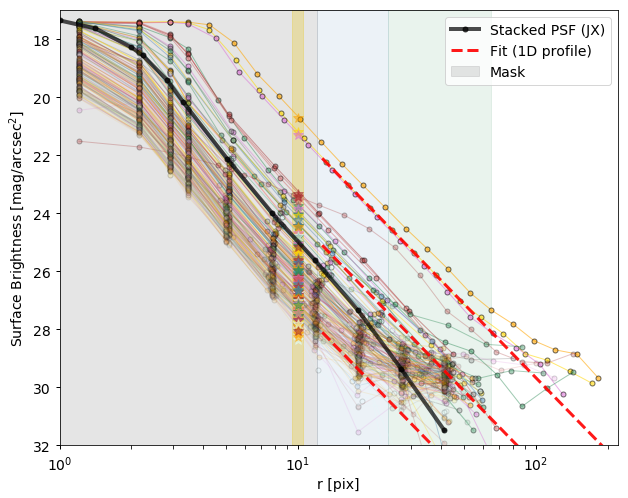

In [39]:
plot_PSF(fit_res1, res_thumb1, plot_stack=PSF_JX_p, mags=[14, 11, 8])

### G-band Patch [3100, 1400, 4100, 2400]  containing brighter stars

Read thumbs from: NGC5907-G-Thumb_15mag_X3100Y1400
Fit results:  [ -0.97171082   3.28641483 462.88711497   5.13372273]


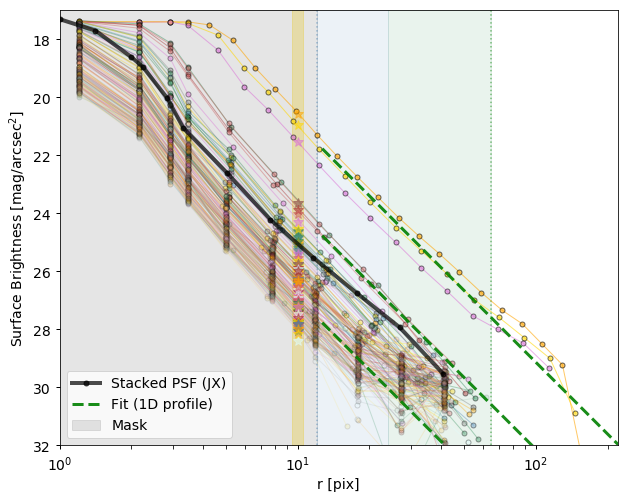

In [54]:
fit_res2 = open_nested_fitting_result(filename='NGC5907-G-fit_best_X3100Y1400.res')
fit_res2 = open_nested_fitting_result(filename='./NGC5907-G-fit_best_X3100Y1400.res')
res_thumb2 = load_thumbs('NGC5907-G-Thumb_15mag_X3100Y1400')
plot_PSF(fit_res2, res_thumb2,  plot_stack=PSF_JX, color='g', mags=[13,10,7])
plt.axvline(65, color="g", ls=":", alpha=0.5)
plt.axvline(12, color="steelblue", ls=":", alpha=0.5)